In [31]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from smooth import smoothen


%matplotlib inline

In [3]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

experiemntal parameters:

v(0): hit/miss, +1 for hit, -1 for miss

v(1): stimulus intensity

v(2): rest of variance

In [4]:
def preprocessing(filename, time='full', windows=None, z_score=True, smooth=True):
    '''
    Preprocesses the data according to specified parameters
    
    filename: string, specifies file to use. If None, concatenate all files
    time: string
        'full' - use full time series of the dendritic Ca2+ signal
        'windowed' - use only one point per dendrite, averaged over specified window
    windows: ndarray, 7x2 or n_filesx7x2. 
        Required in windowed mode. Array holds start- and stop times for each stimulus.
    z_score: bool, whether to z-score the data. 
    '''
    
    assert(not(time=='windowed') or not(windows == None))
    
    #get the data we need into the format we need
    if type(filename) == list:
        #create concatenated data, prompt if file already exitsts
        #in this case, other experiments are interpreted as different units, but same trials as
        #other units. Not all experiments have same units, and not same stimuli, so...later.
        try:
            f = h5py.File('allexp.hdf5', 'w-')
        except OSError:
            print('file already exists, type "continue" to overwrite \n')
            if input() == 'continue':
                f = h5py.File('allexp.hdf5', 'w')
                
        #filename denotes a list of files in this case
        for file in filename:
            #finish later, or probably not
            pass
    else:
        #just load data from specified file
        f = h5py.File(filename+'.hdf5', 'r')
        g = h5py.File(filename[:-6]+"roi.hdf5", "r")
        motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
        
        data = f['data'][:, motion_mask, :]
        meta = f['meta']
    
    if time == 'full':
        #keep all times
        data_pass = data[:]
        if smooth:
            #if we smoothen the data
            data_pass = smoothen(filename)[:,motion_mask,:]
        meta_pass = meta[:]
        
    if time == 'windowed':
        #get window-averaged
        meta_pass = meta[:]
        data_pass = np.zeros((data.shape[0], data.shape[1]))
        
        stims = np.unique(meta[:,1])
        for i, amp in enumerate(stims):
            amp_mask = meta[:,1] == amp
            data_pass[amp_mask] = np.mean(data[amp_mask,:,windows[i,0], windows[i,1]], axis=2)
            
    if z_score:
        #z_score signal
        mns = np.mean(data_pass, axis=0)
        try:
        #specify exception
            mns = np.mean(mns, axis=1)
        except:
            print('Exception triggered')
            
        try:
            stds = np.std(data_pass, axis=(0,2))
        except:
            print('Exception triggered')
            
        mns = np.transpose(np.tile(mns, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        stds = np.transpose(np.tile(stds, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        
        data_pass = data_pass - mns
        data_pass = data_pass/stds
            
    #possibly add functionality for subtracting mean, but not dividing by std.
    return meta_pass, data_pass

In [5]:
def get_betas(meta, data):
    n_trials = data.shape[0]
    n_units = data.shape[1]
    n_times = data.shape[2]
    
    F_i = np.ones((3, n_trials))
    F_i[0, :] = meta[:, 2]
    F_i[1, :] = meta[:, 1]
    
    #tensor math more efficient?
    beta = np.zeros((n_units, n_times, 3))
    F_fac = np.dot(np.linalg.inv(np.dot(F_i, F_i.T)), F_i)
    
    for i in range(n_units):
        for t in range(n_times):
            r_it = data[:,i,t]
            beta[i, t, :] = F_fac.dot(r_it)
            
    return beta

In [288]:
def get_population_response(meta, data):
    '''
    returns ndarray of shape conditions x times x units
    '''
    n_units = data.shape[1]
    n_trials = data.shape[0]
    n_times = data.shape[2]
    
    stims = np.unique(meta[:,1])
    n_stims = stims.shape[0]
    
    #get mask for hit- and miss conditions
    hit_mask = meta[:, 2] == 1
    miss_mask = meta[:, 2] == 0
    
    hit_stim_masks = []
    miss_stim_masks = []
    
    #get masks for all stimulus conditions
    for stim in stims:
        stim_mask = meta[:, 1] == stim
        hit_stim_masks.append(np.logical_and(stim_mask, hit_mask))
        miss_stim_masks.append(np.logical_and(stim_mask, miss_mask))
        
    n_conditions = len(hit_stim_masks) + len(miss_stim_masks)

    x = np.zeros((n_conditions, n_times, n_units))
    #CONVENTION: all hit, then all miss
    
    for i in range(n_conditions):
        if i < len(hit_stim_masks):
            x[i, :, :] = np.mean(data[hit_stim_masks[i]], axis=0).T
        else:
            j = i%len(hit_stim_masks)
            x[i, :, :] = np.mean(data[miss_stim_masks[j]], axis=0).T
            
    return x

In [27]:
def build_X_PCA(meta, data):    
    x = get_population_response(meta, data)
    n_conds = x.shape[0]
    n_times = x.shape[1]
    n_dends = x.shape[2]
    
    X = x.reshape((n_conds*n_times, n_dends))
    
    return X

In [55]:
def scree(X):
    pca = PCA()
    pca.fit(X)
    
    return pca

In [114]:
def do_PCA(X, n_comps=12):
    pca = PCA(n_components=12)
    
    #denoising, but staying in original space!
    X_pca = pca.fit_transform(X)
    
    return pca.inverse_transform(X_pca), pca

In [115]:
def get_beta_pca(beta_re, pca):
    beta_pca = np.zeros((beta_re.shape[0], beta_re.shape[1], beta_re.shape[2]))
    for i in range(beta.shape[2]):
        beta_pca[i,:,:] = pca.inverse_transform(pca.transform(beta_re[i,:,:]))
    return beta_pca

In [147]:
def get_beta_max(beta_pca):
    beta_norms = np.linalg.norm(beta_pca, axis=2)
    t_max = np.argmax(beta_norms, axis=1)
    beta_max = np.zeros((beta_pca.shape[0], beta_pca.shape[2]))

    for i, t in enumerate(t_max):
        beta_max[i,:] = beta_pca[i, t, :]
    
    return beta_max

In [347]:
import matplotlib.offsetbox
from matplotlib.lines import Line2D

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **kwargs)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **kwargs)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **kwargs)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon)

In [542]:
meta, data = preprocessing(filelist[1], time='full', windows=None, z_score=True, smooth=True)

In [543]:
beta = get_betas(meta, data)
beta_re = np.transpose(beta, axes=(2,1,0))

In [544]:
x = get_population_response(meta, data)

In [545]:
X = build_X_PCA(meta, data)

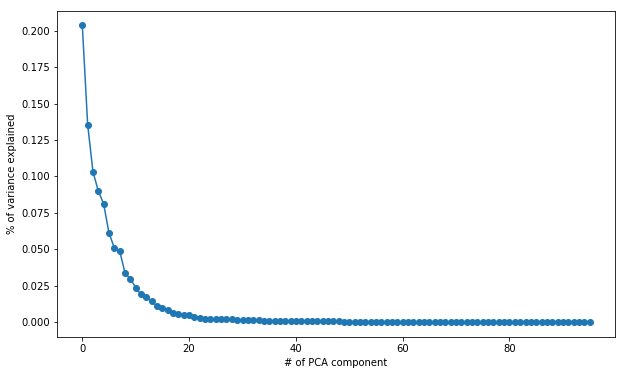

In [546]:
pca = scree(X)

plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel('# of PCA component')
plt.ylabel('% of variance explained')

In [547]:
n_comps = 12
X_pca, pca = do_PCA(X, n_comps=n_comps)

In [548]:
beta_pca = get_beta_pca(beta_re, pca)

In [549]:
beta_max = get_beta_max(beta_pca)

In [550]:
Q, R = np.linalg.qr(beta_max.T)

In [551]:
b_1 = Q[:,0]
b_2 = Q[:,1]

In [552]:
X_ = []
for i in range(14):
    X_.append(x[i])

In [553]:
choice = []
intensity = []
for i in range(14):
    choice.append(np.dot(b_1, X_[i].T))
    intensity.append(np.dot(b_2, X_[i].T))

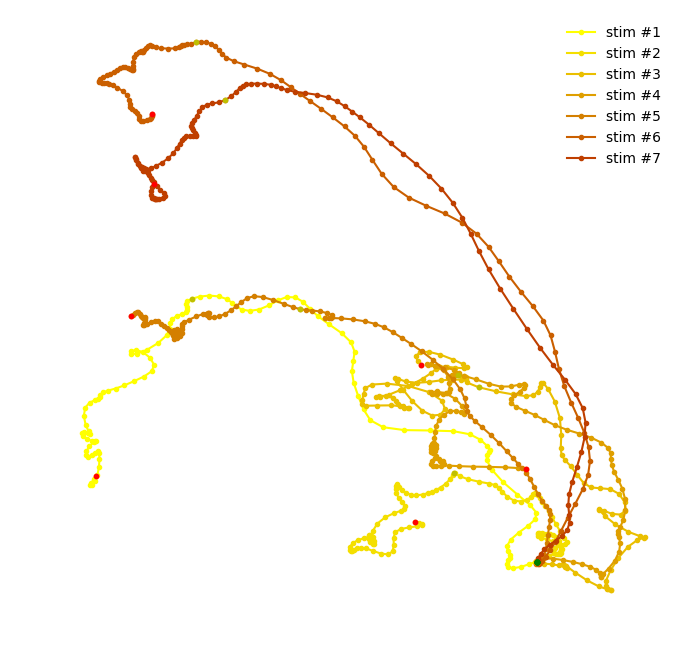

In [554]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i], zorder=1, label='stim #{}'.format(i+1))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

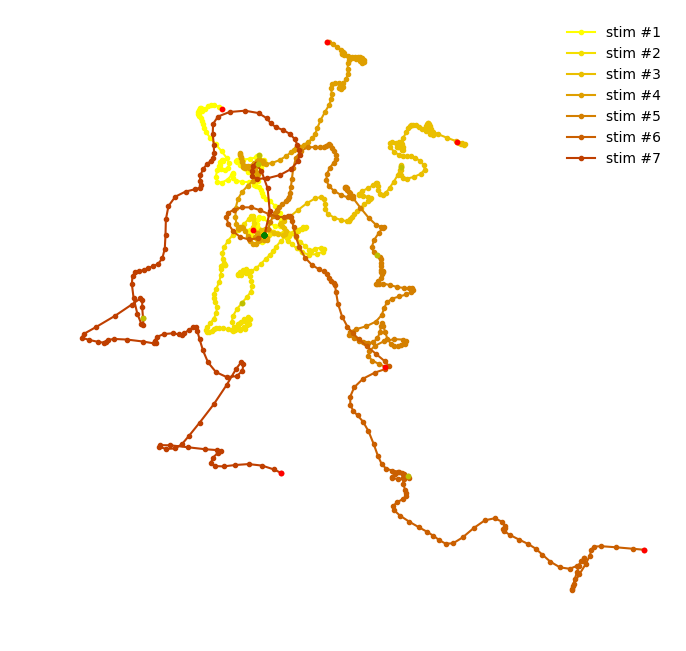

In [555]:
x_ground = choice[7][58]
y_ground = intensity[7][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    i = i+7
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i-7], zorder=1, label='stim #{}'.format(i-6))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

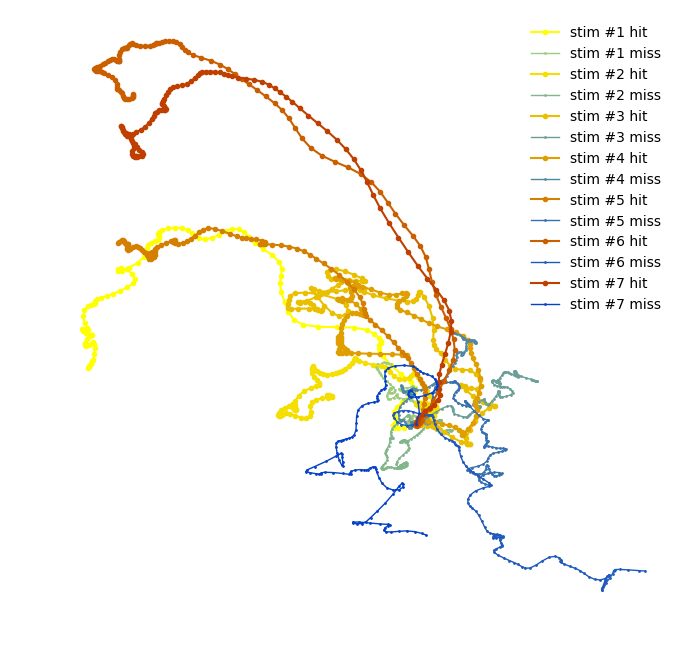

In [556]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]
colors_m = ['#0542C7', '#1E59BB', '#3770AF', '#5187A3', '#6A9E96', '#83B58A', '#9CCC7E'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    c = i
    d = i+7
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    diffxx = choice[i+7][58] - x_ground
    diffyy = intensity[i+7][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i], zorder=1, label='stim #{} hit'.format(i+1))
    plt.plot(choice[d][58:]-diffxx, intensity[d][58:]-diffyy, marker='o', linewidth=1, markersize=1, color=colors_m[i], zorder=1, label='stim #{} miss'.format(i+1))
    #plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    #plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)

    plt.legend(frameon=False)